# Module 4 Project: Financial Instrument Time Series Analysis - Techincal Notebook
### Andrew Cole

In [132]:
#Import necessary libraries, including Helper.py module

import ticker_cleaner
import Auto_ARIMA
import future_dates
import stationarity_check

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as TS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm;

import warnings

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gathering Financial Data and Visualizing Historic Movement

In [96]:
#Use ticker_cleaner module to perform all data gathering and organization into Pandas DF for operation.

xlv_monthly_mean = ticker_cleaner.yahoo_finance_clean('XLV')
xlv_monthly_mean

,Close
Date,
2020-01-01,101.882000
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


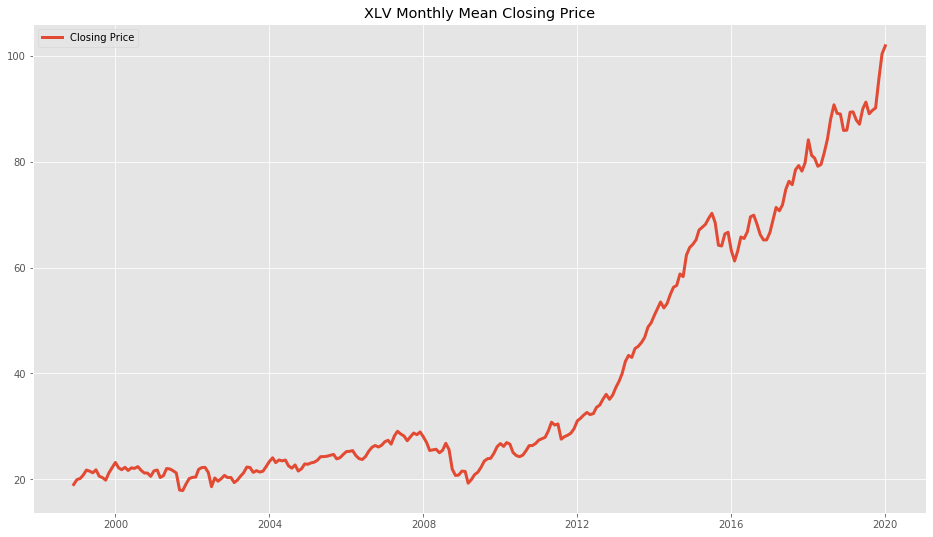

<Figure size 432x288 with 0 Axes>

In [97]:
# Plot the historic movement of XLV's Monthly Mean Closing Price

warnings.filterwarnings(action='always')
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')


## Decomposition

In [98]:
# Use seasonal decomposition function from statsmodels library to seasonally decompose the XLV series after it has been log-transformed

decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

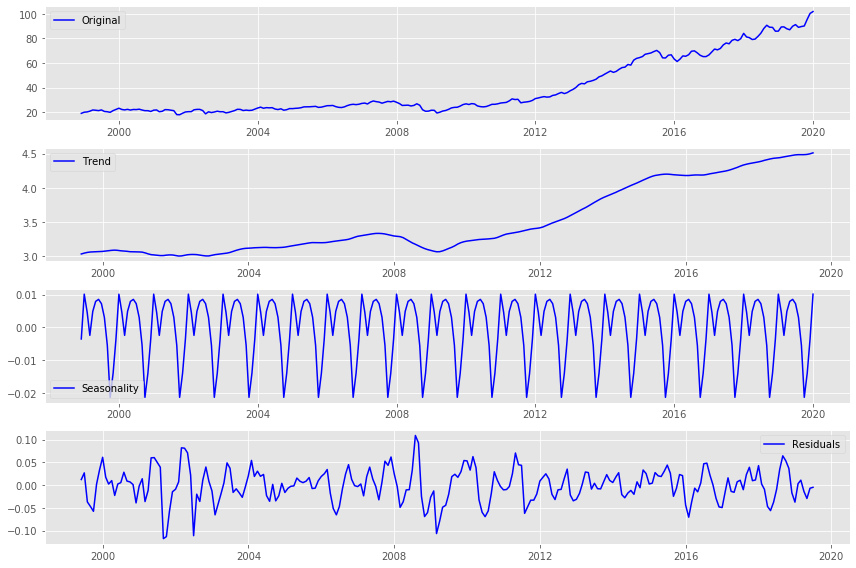

In [99]:
#Visualize trend, seasonality, and residual distribution individually

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## Stationarity Check

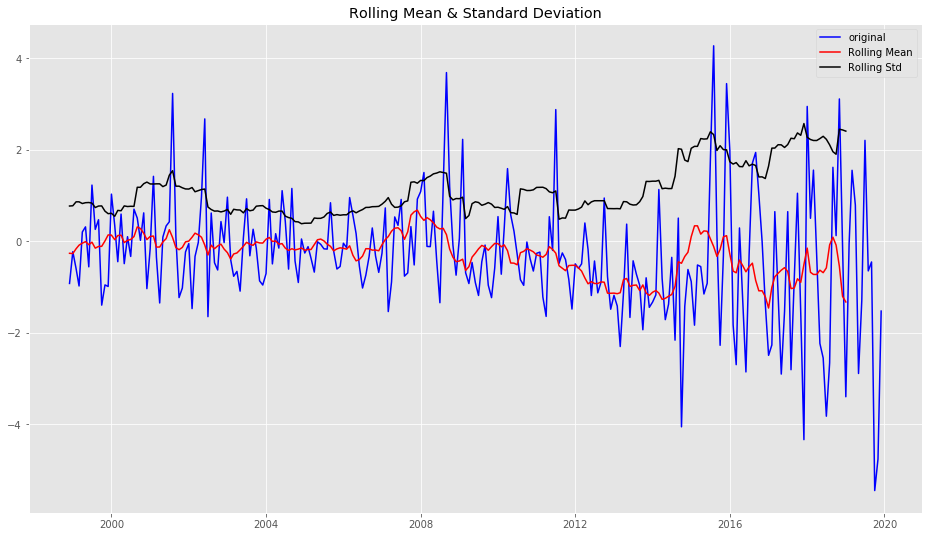

Results of Dickey-Fuller Test
Test Statistic                -1.187997e+01
p-value                        6.211041e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [100]:
# Take a one period difference of the means and perform a stationarity check(Dickey-Fuller Test). Null Hypothesis: The series is NOT stationary.

xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check.stationarity_check(xlv_differenced_mean.Close)

In [101]:
# We can reject the null hypothesis and say that the series is now stationary.

## Model Optimization

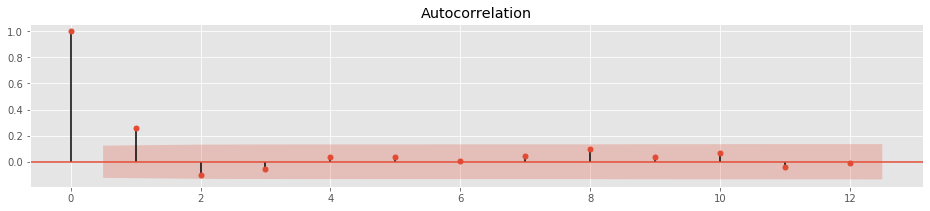

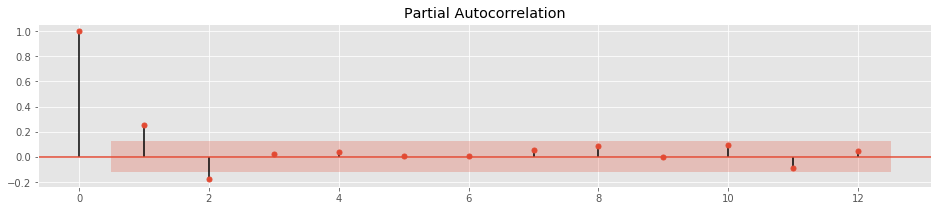

In [102]:
#Plot ACF and PACF functions to get Autoregressive and Moving Average parameters 
fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [103]:
# Run a SARIMA model with order (1,1,2)x(1,1,2,12) to account for seasonality as well. 
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.769
Date:                            Wed, 08 Jan 2020   AIC                            831.538
Time:                                    13:22:12   BIC                            855.932
Sample:                                01-01-2020   HQIC                           841.366
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2840      0.491      0.578      0.563      -0.679       1.247
ma.L1          0.0140      0.491      0.028      0.977      -0.948       0.976
ma.L2         -0.1915      0.149     -1.285      0.199      -0.483       0.101
ar.S.L12      -0.9995      0.066    -15.148      0.000      -1.129      -0.870
ma.S.L12       0.1509      0.561      0.269      0.788      -0.948       1.250
ma.S.L24      -0.8337      0.484     -1.724      0.085      -1.781       0.114
sigma2         1.5753      0.770      2.045      0.041       0.066       3.085
===================================================================================
Ljung-Box (Q):                       31.26   Jarque-Bera (JB):               137.68
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Run a second SARIMA model with order (1,1,1)x(1,1,1,12)) to account for seasonality as well
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.091
Date:                            Wed, 08 Jan 2020   AIC                            834.182
Time:                                    13:22:13   BIC                            851.606
Sample:                                01-01-2020   HQIC                           841.202
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1999      0.169     -1.184      0.237      -0.531       0.131
ma.L1          0.5176      0.155      3.345      0.001       0.214       0.821
ar.S.L12      -0.0766      0.057     -1.353      0.176      -0.188       0.034
ma.S.L12      -0.8334      0.062    -13.384      0.000      -0.955      -0.711
sigma2         1.6752      0.104     16.144      0.000       1.472       1.879
===================================================================================
Ljung-Box (Q):                       31.47   Jarque-Bera (JB):               135.78
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto-ARIMA

In [ ]:
# Utilizes the auto_arima function from Auto_ARIMA.py module to return the best parameter combination which returns the lowest AIC value
Auto_ARIMA.auto_arima()

In [126]:
# Create a copy DF for addition of forecasted values.
xlv_monthly_auto = xlv_monthly_mean.copy()

In [127]:
#Reindex to flip order of time series
xlv_monthly_auto = xlv_monthly_auto.reindex(index=xlv_monthly_mean.index[::-1])

In [139]:
#Re-run ARIMA model using AUTO-ARIMA generated parameters
warnings.filterwarnings(action='once')
Auto_ARIMA = sm.tsa.statespace.SARIMAX(xlv_monthly_auto.Close,
                                       order = (2,2,2),
                                       seasonal_order = (1,1,2,12),
                                       enforce_stationarity = False,
                                       enforce_invertability = False)
output_auto = Auto_ARIMA.fit()
print(output_auto.summary().tables[1])
output_auto.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1746      0.304      0.575      0.565      -0.421       0.770
ar.L2         -0.1986      0.123     -1.618      0.106      -0.439       0.042
ma.L1         -0.8812      0.337     -2.613      0.009      -1.542      -0.220
ma.L2         -0.1167      0.333     -0.350      0.726      -0.770       0.537
ar.S.L12      -0.8398      0.147     -5.727      0.000      -1.127      -0.552
ma.S.L12      -0.1152      0.174     -0.663      0.507      -0.455       0.225
ma.S.L24      -0.6888      0.167     -4.115      0.000      -1.017      -0.361
sigma2         1.6638      0.307      5.413      0.000       1.061       2.266


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -364.704
Date:                            Wed, 08 Jan 2020   AIC                            745.408
Time:                                    15:31:24   BIC                            772.298
Sample:                                12-01-1998   HQIC                           756.275
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1746      0.304      0.575      0.565      -0.421       0.770
ar.L2         -0.1986      0.123     -1.618      0.106      -0.439       0.042
ma.L1         -0.8812      0.337     -2.613      0.009      -1.542      -0.220
ma.L2         -0.1167      0.333     -0.350      0.726      -0.770       0.537
ar.S.L12      -0.8398      0.147     -5.727      0.000      -1.127      -0.552
ma.S.L12      -0.1152      0.174     -0.663      0.507      -0.455       0.225
ma.S.L24      -0.6888      0.167     -4.115      0.000      -1.017      -0.361
sigma2         1.6638      0.307      5.413      0.000       1.061       2.266
===================================================================================
Ljung-Box (Q):                       28.87   Jarque-Bera (JB):                51.37
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.06   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Visualizing the Auto-ARIMA goodness of fit

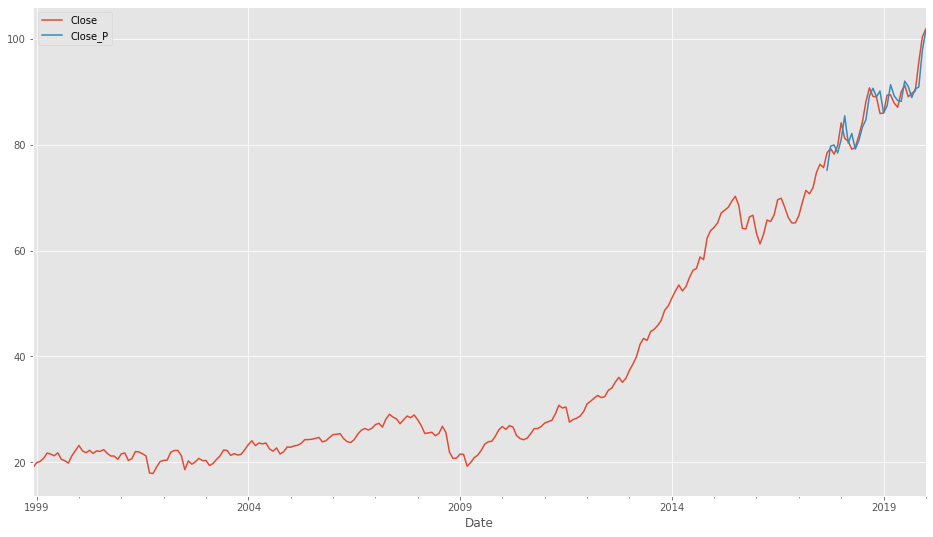

In [129]:
# Create a new feature for predicted monthly mean values and plot over original values
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 225, end = 254, dynamic = False)
xlv_monthly_auto[['Close', 'Close_P']].plot(figsize = (16,9))
plt.legend(loc = 'upper left')
plt.show()


## Forecasting Values and Visualization

In [134]:
# Use future_dates function to create new DataFrame that will hold forecasted values after historic data
future_dates.future_dates(xlv_monthly_auto)

,Close,Close_P
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN
...,...,...
2020-08-01,NaN,NaN
2020-09-01,NaN,NaN
2020-10-01,NaN,NaN
2020-11-01,NaN,NaN


In [137]:
# Obtain forecasted values for 3 years and also obtain a 95% confidence interval for the predicted values
prediction_auto = output_auto.get_forecast(steps = 36)
pred_conf_auto = prediction_auto.conf_int()

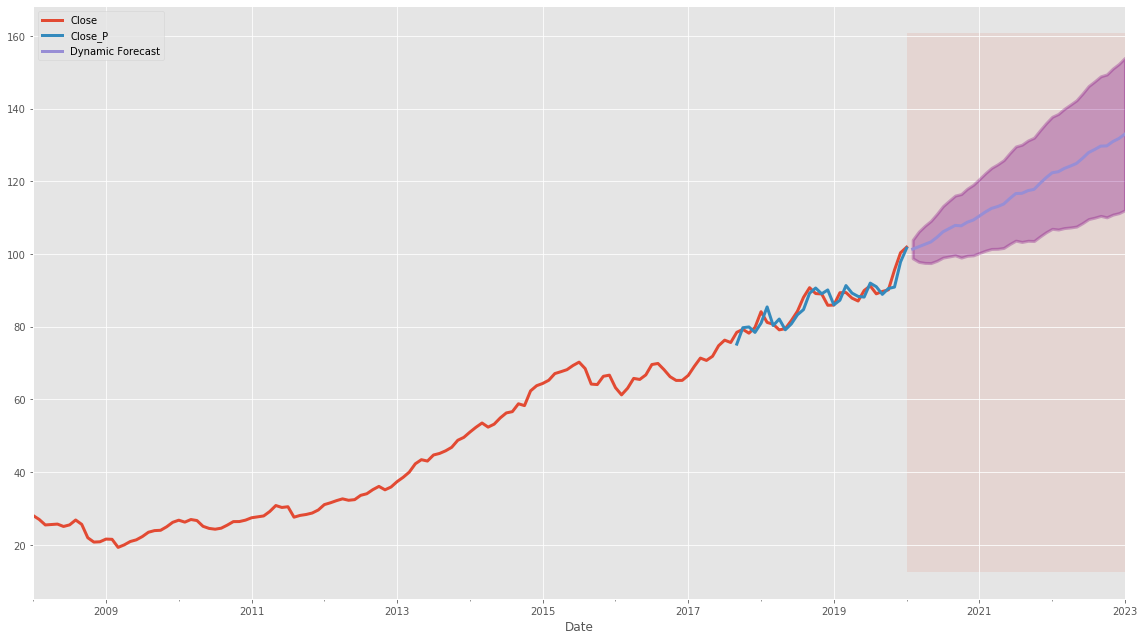

In [138]:
# Visualize original close price projection, predicted values, and confidence intervals
ax = xlv_monthly_auto['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction_auto.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf_auto.index,
                pred_conf_auto.iloc[:,0],
                pred_conf_auto.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('Auto_ARIMA_Projection.png')
plt.show();
